<div>
<img align="left" src="data_sig_logo.jpg" width="450"/>
</div>

### https://datasig.ac.uk/examples

# Path Signatures for Handwritten Digit Classification Using RoughPy

This notebook is based upon the use of path signature techniques to tackle the task of recognising handwritten numerical digits. The dataset considered is the [MNIST sequence data](https://edwin-de-jong.github.io/blog/mnist-sequence-data/) corresponding to the MNIST handwritten digit data set by Edwin D.De Jong.

The task we consider is sequence classification; given a sequence of pen strokes (i.e. pen locations with additional information about the stroke at each given pen location), we aim to predict the digit it represents. As an alternative approach, we disregard information about pen strokes and consider simply the sequence of pen locations. The MNIST sequence dataset is labelled, thus we will initially explore supervised learning approaches. In addition, the notebook explores semi-supervised and unsupervised approaches based upon clustering.

To compute the path signature features for training our models, we use [RoughPy](https://roughpy.org/).

## Set up the Notebook

We begin by setting up the coding environment.

### Install Dependencies

The following cell is only required to be executed if any of the listed packages are not already installed.

In [1]:
# import sys

# !{sys.executable} -m pip install -r requirements.txt

### Import Packages

In [2]:
import joblib
from joblib import Parallel, delayed
import os.path
import tarfile
import urllib.request

import matplotlib.pyplot as plt
import numpy as np

import MNIST_funcs

The module `MNIST_funcs` is a collection of documented functions, written for the task of applying path signature techniques to the MNIST sequence classification task.

### Download the Dataset

The MNIST sequence dataset is stored in a compressed tarfile format with the extension `tar.gz`. We first download this compressed tarfile, before opening it and extracting its contents to a directory named `mnist_data` below the current working directory.

In [3]:
MNIST_DOWNLOAD_URL = "https://raw.githubusercontent.com/edwin-de-jong/mnist-digits-stroke-sequence-data/master/sequences.tar.gz"

TARGET_FILE = "sequences.tar.gz"
DATA_DIRECTORY = "mnist_data"

if not os.path.exists(DATA_DIRECTORY):
    print("Downloading data...")
    urllib.request.urlretrieve(MNIST_DOWNLOAD_URL, TARGET_FILE)

    print("Extracting data...")
    tar = tarfile.open(TARGET_FILE)
    tar.extractall(DATA_DIRECTORY)
    tar.close()

Extracting data...


## Extract Sequences

We next extract the pen-stroke sequences, the location sequences and the labels contained in the `mnist_data` directory. The contents are pre-split into $60\,000$ training instances and $10\,000$ testing instances. We carry out the extraction using the `mnist_train_data` and `mnist_test_data` functions from the `MNIST_funcs` package, which are documented as follows:

In [4]:
help(MNIST_funcs.mnist_train_data)

Help on function mnist_train_data in module MNIST_funcs:

mnist_train_data(data_directory: str, cpu_number: int) -> tuple[list[numpy.array], list[numpy.array], list[int]]
    Read the training data from the specified directory.
    
    Parameters
    ----------
    data_directory : str
        The directory containing the MNIST sequences data
    cpu_number : int
        The number of cpus to use for parallelisation
    
    Returns
    -------
    tuple[list[np.array], list[np.array], list[int]]
        The first item is a list of the streams formed by the 2D
        points data, the second is a list of streams of the 3D input data recording
        in the first two entries the change in x and y coordinates from the previous
        point and when the pen leaves the paper in the third entry. The fourth
        coordinate used to indicate when one figure ends and the next begins is
        ignored in this extraction. See the MNIST sequences project website for full
        details. Th

In [5]:
help(MNIST_funcs.mnist_test_data)

Help on function mnist_test_data in module MNIST_funcs:

mnist_test_data(data_directory: str, cpu_number: int) -> tuple[list[numpy.array], list[numpy.array], list[int]]
    Read the test data from the specified directory.
    
    Parameters
    ----------
    data_directory : str
        The directory containing the MNIST sequences data
    cpu_number : int
        The number of cpus to use for parallelisation
    
    Returns
    -------
    tuple[list[np.array], list[np.array], list[int]]
        The first is a list of the streams formed by the 2D
        points data, the second is a list of streams of the 3D input data recording
        in the first two entries the change in x and y coordinates from the previous
        point and when the pen leaves the paper in the third entry. The fourth
        coordinate used to indicate when one figure ends and the next begins is
        ignored in this extraction. See the MNIST sequences project website for full
        details. The third ret

In [6]:
N_CPU = joblib.cpu_count()
train_points, train_inputs, train_targets = MNIST_funcs.mnist_train_data(
    data_directory=DATA_DIRECTORY, cpu_number=N_CPU
)
test_points, test_inputs, test_targets = MNIST_funcs.mnist_test_data(
    data_directory=DATA_DIRECTORY, cpu_number=N_CPU
)

We use used every available CPU for parallelisation. Depending on your hardware this may not be the best option, and you might prefer to change `N_CPU` to a more suitable choice.

With the sequences and labels extracted, we will examine an example sequence:

In [7]:
index = 2
train_points[index]

array([[ 5.,  9.],
       [ 5., 10.],
       [ 5., 11.],
       [ 5., 12.],
       [ 5., 13.],
       [ 4., 14.],
       [ 4., 15.],
       [ 5., 16.],
       [ 6., 16.],
       [ 7., 16.],
       [ 8., 16.],
       [ 9., 16.],
       [10., 16.],
       [11., 16.],
       [12., 16.],
       [13., 16.],
       [14., 15.],
       [15., 15.],
       [16., 15.],
       [17., 15.],
       [18., 15.],
       [19., 15.],
       [19., 16.],
       [19., 17.],
       [19., 18.],
       [18., 19.],
       [18., 20.],
       [18., 21.],
       [18., 22.],
       [18., 23.],
       [-1., -1.],
       [19., 14.],
       [20., 13.],
       [20., 12.],
       [20., 11.],
       [21., 10.],
       [21.,  9.],
       [22.,  8.],
       [22.,  7.],
       [22.,  6.]])

In [8]:
train_points[index].shape

(40, 2)

The first array captures the locations of the pen tip as the digit is drawn.

In [9]:
train_inputs[index]

array([[ 5.,  9.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1., -9.,  0.],
       [ 1., -1.,  0.],
       [ 0., -1.,  0.],
       [ 0., -1.,  0.],
       [ 1., -1.,  0.],
       [ 0., -1.,  0.],
       [ 1., -1.,  0.],
       [ 0., -1.,  0.],
       [ 0., -1.,  0.]])

In [10]:
train_inputs[index].shape

(40, 3)

The second array captures the same information in its first two columns (interpreted as horizontal and vertical changes from the previous location) whilst its third column records the number of strokes (the presence of a $1$ indicates a stroke ending; so the digit in this example is drawn via two separate strokes).

In [11]:
train_targets[index]

np.int64(4)

Finally, the third returned value is the sequences label telling us that this sequence corresponds to a $4$.

## Path Signature Methodology

The classification problem that we consider consists of learning how to use either of the two sequences to accurately predict the label. The piecewise linear interpolation of the sequence of locations forms a continuous path in $\mathbb{R}^2$, and the piecewise linear interpolation of the sequence of pen strokes forms a continuous path in $\mathbb{R}^3$. The challenge involves understanding the effect of these paths.

### The Path Signature

The path signature is a central object in the mathematical field of rough path theory. It efficiently summarises paths such as the ones examined above in an essentially unique manner. The path signature is independent of the path's time parameterisation, yet it still preserves the order in which events happen. The invariance to sampling rate is desirable, since the digit drawn is invariant to the speed at which it was drawn; a figure $3$ is a figure $3$ regardless of how quickly it is drawn. Moreover, this invariance ensures that the differing lengths of sequences is not an issue.

In mathematical terms, the signature of a path $\gamma : [0,1] \to \mathbb{R}^d$ is the response of the exponential nonlinear system to the path. That is, the signature $S(\gamma)$ is the solution to the universal differential equation
$$ d S(\gamma) = S \otimes d\gamma $$
living in the tensor algebra $T \left( \mathbb{R}^d \right)$.
For the piecewise linear paths obtained via interpolation of the sequences of locations and pen strokes, the signature can be expressed in terms of iterated integrals of the paths. Namely, if $\gamma : [0,1] \to \mathbb{R}^d$ is piecewise linear, then its signature is given by 
$$ S_{0,t}(\gamma) = \bigoplus_{n=0}^{\infty} S_{0,t}^n (\gamma)$$
where
$$ S^0_{0,t}(\gamma) \equiv 1 \qquad \text{and} \qquad S^n_{0,t}(\gamma) = \idotsint\limits_{0 < t_1 < \ldots < t_n < t} d \gamma_{t_1} \otimes \ldots \otimes d \gamma_{t_n} \qquad \text{for} \qquad n \geq 1.$$
By linearity, for each $n \geq 1$ we have
$$S^n_{0,t}(\gamma) = \sum_{i_1 = 1}^d \ldots \sum_{i_n = 1}^d \left( \quad \idotsint\limits_{0 < t_1 < \ldots < t_n < t} d \gamma^{i_1}_{t_1} \ldots d \gamma^{i_n}_{t_n} \right) e_{i_1} \otimes \ldots \otimes e_{i_n}$$
for the standard orthonormal basis $e_1 , \ldots , e_d \in \mathbb{R}^d$ and where each of the $n$ integrations is along one coordinate axis.
Hence the level $n$ term of the signature $S^n_{0,t}(\gamma)$ contains the collection of real numbers 
$$ S^n_{0,t}(\gamma)^{(i_1,\ldots,i_n)} = \idotsint\limits_{0 < t_1 < \ldots < t_n < t} d \gamma^{i_1}_{t_1} \ldots d \gamma^{i_n}_{t_n} \in \mathbb{R}$$
for every possible choice of indices $i_1 , \ldots , i_n \in \{1, \ldots , d\}$.
There are $d^n$ such choices, illustrating that the number of terms in the signature at level $n$ grows exponentially with $n$.

Making practical use of signatures requires overcoming the issue that the full signature is an infinite sequence of iterated integrals. We follow the most common solution of choosing a finite truncation level $N \in \mathbb{N}$, and considering the truncated signature
$$ S^{(N)}_{0,t} (\gamma) = \bigoplus_{n=0}^N S^n_{0,t}(\gamma),$$
i.e. only considering the iterated integrals of the path up to level $N$.
The exponential growth of the number of integrals in each new level mean it is common to only consider low-level ($N \leq 10$) truncations.

More details about the path signature may be found, for example, in any of the following references:
 - I. Chevyrev and A. Kormilitzin, "A Primer on the Signature Method in Machine Learning", arXiv preprint arXiv:1603.03788, 2016, https://arxiv.org/pdf/1603.03788.pdf
 - T. Lyons, "Rough paths, Signatures and the modelling of functions on streams", In Proceedings of the International Congress of Mathematicians: Seoul, pp. 163‐184, 2014, (available on arXiv: https://arxiv.org/pdf/1405.4537.pdf)
 - T. Lyons, M. J. Caruana and T. Lévy, "Differential Equations Driven by Rough Paths: Ecole d’Eté de Probabilités de Saint-Flour XXXIV-2004", Lecture Notes in Mathematics École d'Été de Probabilités de Saint-Flour, Springer 2007, DOI https://doi.org/10.1007/978-3-540-71285-5
 
For the moment we will focus on using the paths in $\mathbb{R}^2$ generated by interpolating the sequences of locations. Thus we consider piecewise linear paths $\gamma : [0,1] \to \mathbb{R}^2$, and we will compute the truncated signature $S^{(N)}(\gamma)$ for some $N \in \mathbb{N}$.
The truncated signature $S^{(N)}(\gamma)$ consists of $\sum_{i=0}^N 2^i = 2^{N+1} - 1$ terms, thus choosing $N=8$ (for example) will involve computing $511$ integrals for each path (although since the leading term of a signature is always $1$, it is really only $510$ computations).

Before computing the signatures, we first normalise the sequences of locations. There are two options for normalisation built into `MNIST_funcs`; namely, `stream_normalise_mean_and_range` and `stream_normalise_mean_and_std`:

In [12]:
help(MNIST_funcs.stream_normalise_mean_and_range)

Help on function stream_normalise_mean_and_range in module MNIST_funcs:

stream_normalise_mean_and_range(stream: <built-in function array>) -> <built-in function array>
    Normalise the input stream to have mean 0 and be in [-1,1] in each channel.
    
    Parameters
    ----------
    stream : np.array
        A two-dimensional numpy array of shape [length x dimension]
    
    Returns
    -------
    np.array
        A copy of the input stream, retaining the same shape, but scaled
        to have mean 0 and coordinates/channels in [-1,1]



In [13]:
help(MNIST_funcs.stream_normalise_mean_and_std)

Help on function stream_normalise_mean_and_std in module MNIST_funcs:

stream_normalise_mean_and_std(stream: <built-in function array>) -> <built-in function array>
    Normalise the input stream to have mean 0 and standard deviation 1 in each channel.
    
    Parameters
    ----------
    stream : np.array
        A two-dimensional numpy array of shape [length x dimension]
    
    Returns
    -------
    np.array
        A copy of the input stream, retaining the same shape, but scaled
        to have mean 0 and standard deviation 1.0



We use both these normalisations as a pre-processing step, before using the [RoughPy package](https://roughpy.org/) developed by Sam Morley, Terry Lyons et al. to compute path signatures truncated to level $8$. We also apply the normalisation to the sequences of pen strokes, and compute the truncated signature of the resulting paths.

In [14]:
help(MNIST_funcs.compute_signatures_with_normalisation)

Help on function compute_signatures_with_normalisation in module MNIST_funcs:

compute_signatures_with_normalisation(train_points: list[numpy.array], test_points: list[numpy.array], depth: int, normalisation: <built-in function callable>, n_jobs: int) -> tuple[list[numpy.array], list[numpy.array]]
    Compute the signatures of the input streams, truncated to the given depth,
    using the given normalisation function and parallelising the computation
    over the given number of cpus.
    
    Parameters
    ----------
    train_points : list[np.array]
        A list of numpy arrays, each of shape [length x dimension]
    test_points : list[np.array]
        A list of numpy arrays, each of shape [length x dimension]
    depth : int
        The depth to which the signature should be truncated
    normalisation : callable
        A function to normalise the input streams. Applied to each stream
        in train_points and test_points before computing the signature
    n_jobs : int
      

In [15]:
from MNIST_funcs import stream_normalise_mean_and_range as snmr
from MNIST_funcs import stream_normalise_mean_and_std as snms
from MNIST_funcs import compute_signatures_with_normalisation

SIGNATURE_LEVEL = 8

train_sigs_snmr, test_sigs_snmr = compute_signatures_with_normalisation(
    train_points=train_points,
    test_points=test_points,
    depth=SIGNATURE_LEVEL,
    normalisation=snmr,
    n_jobs=N_CPU,
)
train_sigs_snms, test_sigs_snms = compute_signatures_with_normalisation(
    train_points=train_points,
    test_points=test_points,
    depth=SIGNATURE_LEVEL,
    normalisation=snms,
    n_jobs=N_CPU,
)

### The Signature is a Universal Nonlinearity

We can think of the signature as a __"Universal Nonlinearity"__ in the sense that every continuous function of a path may be approximated arbitrarily well by a linear function of its signature.
Thus, one approach we can consider is to learn a _simple linear function_ on top of our signature features to perform classification. 
However, the arbitrary accuracy in approximation is only guaranteed by allowing the truncation level to become arbitrarily high. This can lead to significant time delays, and in the interest of speed for this Notebook, we are limiting ourselves to considering level $8$ truncations.

### Signature Term Size

The level $N$ signature terms are all of magnitude $\mathcal{O}\left( \frac{1}{N!} \right)$.
Thus, there is a fast decay of the signature terms' magnitudes as the signature level increases. This can quickly lead to numerical precision issues when performing calculations involving multiple terms. 
To avoid such numerical precision issues, we will consider various rescalings of the signatures to be used as the feature set for classification. These rescalings will **not** involve re-computing the signatures. We re-scale in such a way that the level $N$ terms are rescaled a the factor of $r^N$, with $r > 0$. This is achieved via the `sig_scale_depth_ratio` function included in `MNIST_funcs`:

In [16]:
help(MNIST_funcs.sig_scale_depth_ratio)

Help on function sig_scale_depth_ratio in module MNIST_funcs:

sig_scale_depth_ratio(sig: <built-in function array>, dim: int, depth: int, scale_factor: float) -> <built-in function array>
    The returned output is a numpy array of the same shape as the input signature, sig.
    Each entry in the returned array is the corresponding entry in sig multiplied by r^k,
    where k is the level of sig to which the entry belongs.
    
    If the input depth is 0, an error message is returned since the scaling will always
    leave the level zero entry of a signature as 1.
    
    Parameters
    ----------
    sig : np.array
        A one-dimensional numpy array of length 1+dim+dim^2+...+dim^depth corresponding
        to the signature of a stream of dimension dim and truncated to level depth.
    dim : int
        Dimension of the input stream
    depth : int
        Level to which the input signature is truncated
    scale_factor : float
        The scaling factor to be applied to the signa

## Supervised Learning

In this notebook we train off-the-shelf classifier implementations available using the Scikit-Learn python package. We will consider multiple possible rescaling values $r>0$. For each chosen rescaling value, we rescale the path signatures using the `sig_scale_depth_ratio` function. We use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to fine-tune model hyper-parameters. We optimise the rescaling parameter $r>0$ by computing [accuracy scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and by recording the best performing model and the scaling parameter it used.

We will use the [`RidgeClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html) model from Scikit-Learn. For this model the `ridge_learn` function from `MNIST_funcs` executes a GridSearchCV for a fixed choice of rescaling parameter $r$, whilst the `ridge_scale_learn` function executes GridSearchCV for a range of scale factors chosen by the user. For simplicity, we optimise only the _alphas_ hyper-parameter using GridSearchCV, setting all other model hyper-parameters their [default values](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html).

In [17]:
help(MNIST_funcs.ridge_learn)

Help on function ridge_learn in module MNIST_funcs:

ridge_learn(scale_factor: float, dim: int, depth: int, data: list[numpy.array], labels: list[int], CV: Any = None, reg: list[numpy.array] = [array([ 0.1,  1. , 10. ])], cpu_number: int = 1) -> tuple[float, sklearn.linear_model._ridge.RidgeClassifierCV, float]
    Fit a RidgeClassifierCV model to the input data, using the given scale factor.
    
    The entries in the data list are scaled via the sig_scale_depth_ratio
    function, i.e. via sig_scale_depth_ratio(data, dim, depth,
    scale_factor=scale_factor), and cpu_number number of cpus are used for
    parallelisation.
    
    Once scaled, a sklearn GridSearchCV is run with the model set to be
    RidgeClassifierCV(), the param_grid to be {'alphas':reg} and the
    cross-validation strategy to be determined by CV.
    
    The selected best model is used to predict the labels for the appropriately
    scaled data, and the accuracy_score of the predicted labels compared to the
 

In [18]:
help(MNIST_funcs.ridge_scale_learn)

Help on function ridge_scale_learn in module MNIST_funcs:

ridge_scale_learn(scale_factors: list[float], dim: int, depth: int, data: list[numpy.array], labels: list[int], CV: Any = None, reg: list[numpy.array] = [array([ 0.1,  1. , 10. ])], cpu_number_one: int = 1, cpu_number_two: int = 1) -> tuple[list[tuple[float, sklearn.linear_model._ridge.RidgeClassifierCV, float]], tuple[float, sklearn.linear_model._ridge.RidgeClassifierCV, float]]
    Fit a RidgeClassifierCV model to the input data, using the given scale factors.
    
    The returned outputs are a list of the results of ridge_learn(r, dim, depth,
    data, labels, CV, reg) for each entry r in scale_factors, and a separate
    recording of the output corresponding to the entry r in scale_factors for
    which the best accuracy_score is achieved The integer cpu_number_one
    determines how many cpus are used for parallelisation over the scale_factors,
    whilst cpu_number_two determines the number of cpus used for parallelisati

In the following cell, we use the level $8$ truncated signatures coming from the paths of locations after they are rescaled so that each component has mean $0$ and resides in the interval $[-1,1]$. 
We consider the scale factors $r \in \{ 1 , 2 , 3 , 4 \}$ for each model.

Assuming that the machine has _hyperthreaded cores_, we use N_CPU//4 for _cpu_number_one_ and _cpu_number_two_ as a means of speeding up computation. You may wish to experiment with different values, depending on your machine.

In [19]:
E = np.linspace(1.0, 4.0, 4)
from MNIST_funcs import ridge_scale_learn

ridge_results_snmr, ridge_best_result_snmr = ridge_scale_learn(
    scale_factors=E,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_snmr,
    labels=train_targets,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

In the following cell, we use the level $8$ truncated signatures coming from the paths of locations after they are rescaled so that each component has mean $0$ and standard deviation $1$. 
We consider the scale factors $r \in \{ 0.01 , 0.1 , 1 , 10 \}$ for each model.

In [20]:
EB = np.linspace(0.5, 2.0, 4)

ridge_results_snms, ridge_best_result_snms = ridge_scale_learn(
    scale_factors=EB,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_snms,
    labels=train_targets,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

### Evaluate Model Performance

To measure performance on the testing set we use the `model_performance` function from `MNIST_funcs`:

In [21]:
help(MNIST_funcs.model_performance)

Help on function model_performance in module MNIST_funcs:

model_performance(B: tuple[float, typing.Any], dim: int, depth: int, data: list[numpy.array], labels: list[int], cpu_number: int) -> tuple[float, typing.Any, float, numpy.array, numpy.array]
    Compute model performance using the given model B and the input data.
    Compute the accuracy_score, the confusion matrix and a normalised confusion_matrix.
    
    The entries in the data list are scaled via the sig_scale_depth_ratio
    function with B[0] as the scale_factor, i.e. sig_scale_depth_ratio(data,
    dim, depth, scale_factor = B[0]).
    
    The model B[1] is used to make predictions using the rescaled data, and the
    accuracy_score, the confusion matrix and a normalised confusion_matrix
    (focusing only on the incorrect classifications) of these predictions
    compared to the labels are computed.
    
    The returned outputs are the scale_factor B[0] used, the model B[1] used, the
    accuracy_score achieved, the

In [22]:
from MNIST_funcs import model_performance

best_ridge_snmr = model_performance(
    B=ridge_best_result_snmr,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_snmr,
    labels=test_targets,
    cpu_number=N_CPU,
)
best_ridge_snms = model_performance(
    B=ridge_best_result_snms,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_snms,
    labels=test_targets,
    cpu_number=N_CPU,
)

### Testing Set Performance - Location Sequences

#### Ridge Classifier Results

To examine the performance of the best Ridge models we print the confusion matrix and a normalised confusion matrix which highlights only the incorrect classifications.

We first do this for the best Ridge model achieved using the mean and range renormalised paths.

In [23]:
print(
    "The best Ridge model using the mean and range renormalised paths achieved an "
    f"accuracy_score of {best_ridge_snmr[2]} on the testing set and corresponds "
    f"to using the scalefactor {best_ridge_snmr[0]}"
)

The best Ridge model using the mean and range renormalised paths achieved an accuracy_score of 0.8931 on the testing set and corresponds to using the scalefactor 4.0


In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = list(range(10))


def plot_confusion_matrix(cm: np.array) -> None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    cm_display.plot(ax=ax)

#### Ridge Confusion Matrix (snmr)

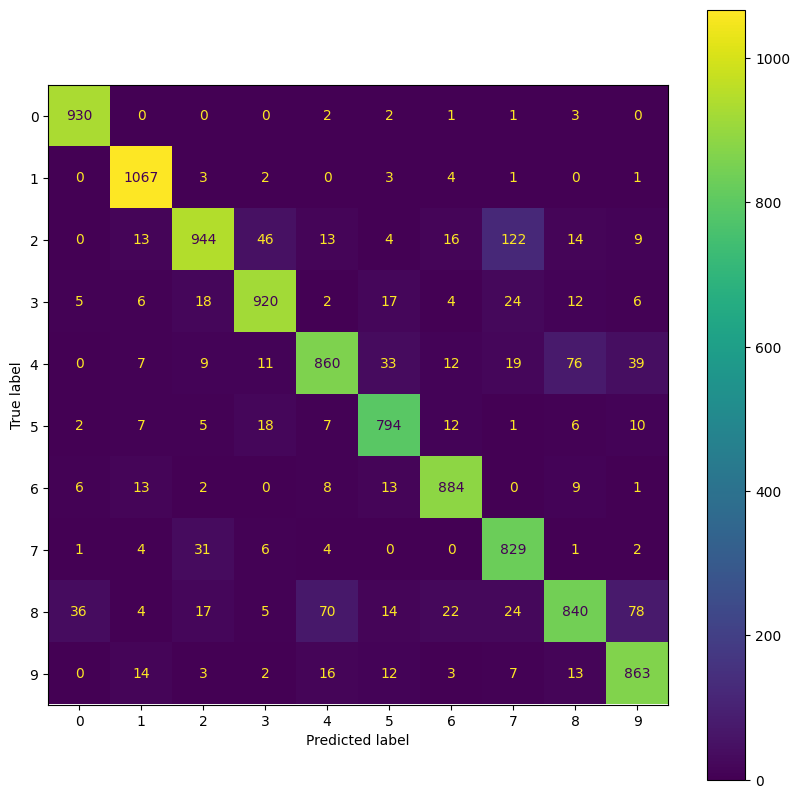

In [25]:
plot_confusion_matrix(best_ridge_snmr[3])

#### Ridge Normalised Error-Only Confusion Matrix (snmr)

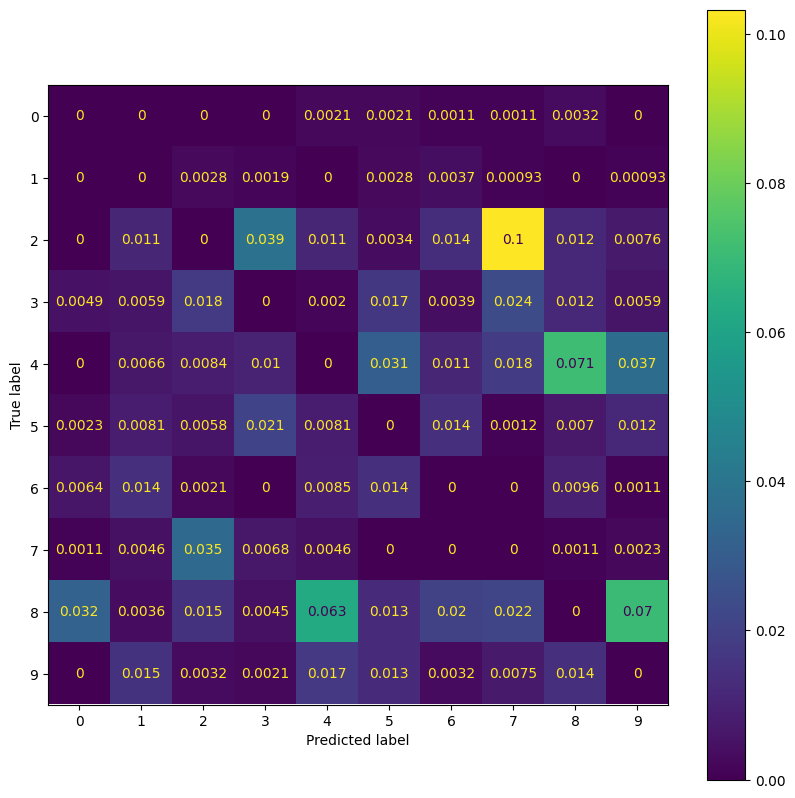

In [26]:
plot_confusion_matrix(best_ridge_snmr[4])

Now we turn our attention to the best Ridge model achieved using the mean and standard deviation renormalised paths.

In [27]:
print(
    "The best Ridge model using the mean and standard deviation renormalised paths achieved an "
    f"accuracy_score of {best_ridge_snms[2]} on the testing set and corresponds "
    f"to using the scalefactor {best_ridge_snms[0]}"
)

The best Ridge model using the mean and standard deviation renormalised paths achieved an accuracy_score of 0.9125 on the testing set and corresponds to using the scalefactor 1.5


#### Ridge Confusion Matrix (snms)

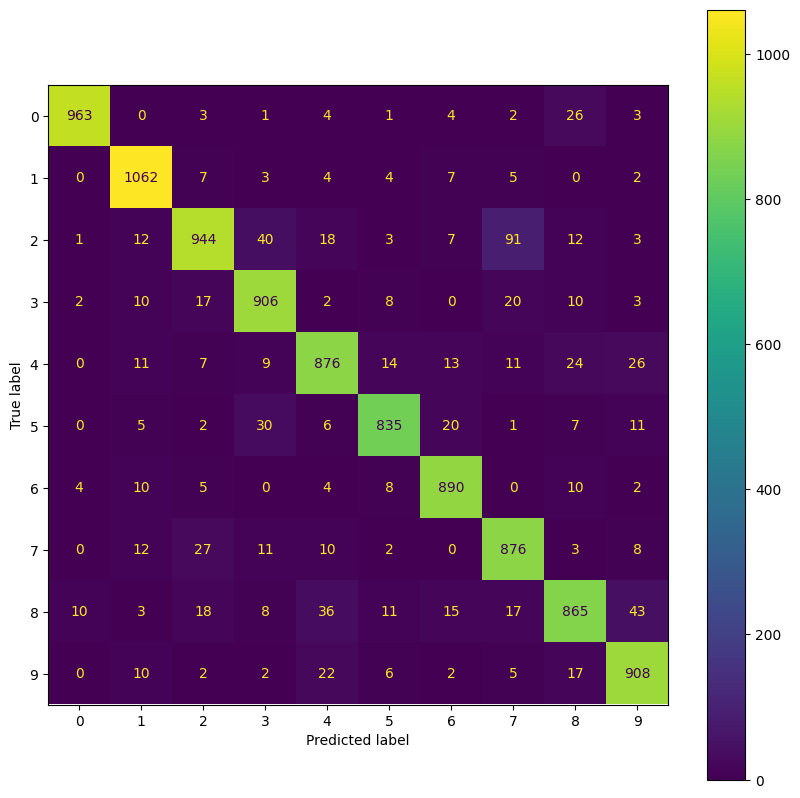

In [28]:
plot_confusion_matrix(best_ridge_snms[3])

#### Ridge Normalised Error-Only Confusion Matrix (snms)

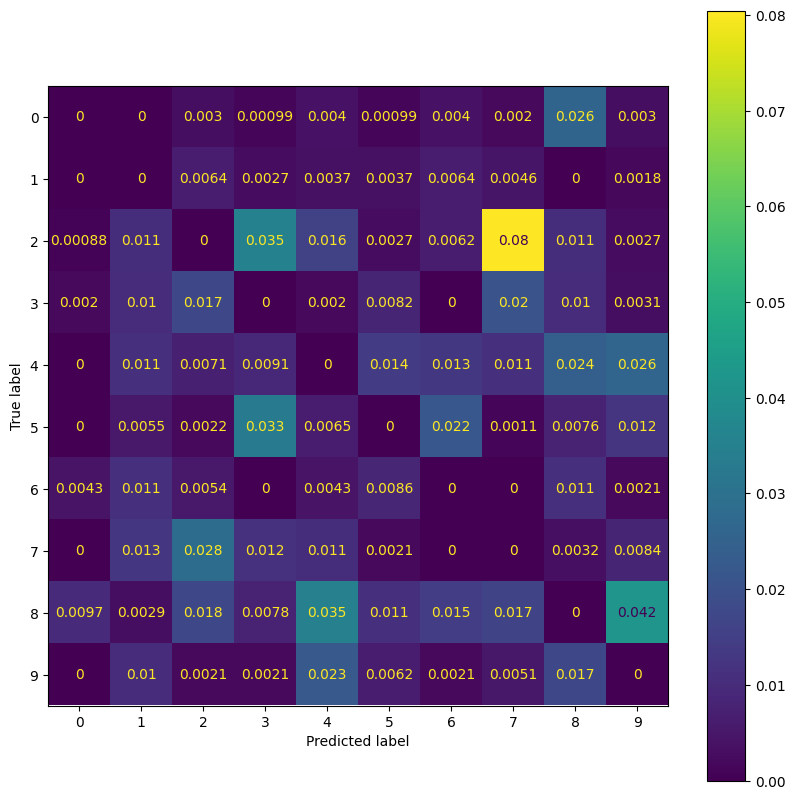

In [29]:
plot_confusion_matrix(best_ridge_snms[4])

The accuracy scores achieved on the testing set are summarised in the following table. 
In the 'Sequence Normalisation' column, _snmr_ means that the signatures were computed from the location sequences normalised to have mean $0$ and live in $[-1,1]$, whilst _snms_ means the signatures were computed from the location sequences normalised to have mean $0$ and standard deviation $1$. The model returning the highest accuracy score is highlighted in bold.

| Model | Sequence Normalisation | Accuracy (%) |
| :-: | :-: | :-: |
| Ridge | snmr | 89.31 |
| Ridge | snms | 91.25 |

An issue is misclassification of $2$'s and $7$'s, with quite a few $2$'s getting incorrectly classified as $7$'s. Whilst using higher level signatures may solve this problem it will also be costly, with the number of terms involved in each signature roughly doubling with each new level included. An alternative solution is offered by considering the pen stroke sequences instead; drawing a $7$ often requires two strokes, whereas drawing a $2$ only requires a single stroke.

### Pen Strokes Sequences

Thus far we have only used the location sequences in $\mathbb{R}^2$. Now we turn our attention to the pen stroke sequences in $\mathbb{R}^3$. Rather than use the raw pen stroke sequence, we will first replace each sequence by the sequence of its cumulative sums. That is, the sequence whose $n^{th}$ entry is the sum of the first $n$ entries of the original sequence.

The resulting sequence will have its first two components exactly the same as the location sequence, but the additional third component will now count the number of strokes involved (with $0$ meaning there is only a single stroke, $1$ meaning there is two strokes, and so on). The signatures of these paths will still capture all the location information as well as additionally capturing information about the number of strokes. As mentioned above, it seems plausible that the number of strokes should help distinguish between a $2$ and a $7$.

In effect we are considering an _Invisibility Reset-Like_ transformation of each sequence of locations. We have introduced a new dimension to the sequence and only make this new dimension visible if the number of strokes increases above $1$.

We start by obtaining the invisibility reset location sequences from the pen stroke sequences by using the `invisibility_reset_like_sum` function from `MNIST_funcs`.

In [30]:
help(MNIST_funcs.invisibility_reset_like_sum)

Help on function invisibility_reset_like_sum in module MNIST_funcs:

invisibility_reset_like_sum(stream: <built-in function array>) -> <built-in function array>
    Apply the invisibility reset-like sum transformation to the input stream.
    
    Parameters
    ----------
    stream : np.array
        Stream of data
    
    Returns
    -------
    np.array
        Stream of data with the n^th entry in the output given by the
        component-wise sum of the first n entries in stream



In [31]:
from MNIST_funcs import invisibility_reset_like_sum

train_points_ir = Parallel(n_jobs=N_CPU)(
    [delayed(invisibility_reset_like_sum)(q) for q in train_inputs]
)
test_points_ir = Parallel(n_jobs=N_CPU)(
    [delayed(invisibility_reset_like_sum)(q) for q in test_inputs]
)

Below is an example comparing these new transformed sequences with the original sequences of locations.

In [32]:
train_points[index]

array([[ 5.,  9.],
       [ 5., 10.],
       [ 5., 11.],
       [ 5., 12.],
       [ 5., 13.],
       [ 4., 14.],
       [ 4., 15.],
       [ 5., 16.],
       [ 6., 16.],
       [ 7., 16.],
       [ 8., 16.],
       [ 9., 16.],
       [10., 16.],
       [11., 16.],
       [12., 16.],
       [13., 16.],
       [14., 15.],
       [15., 15.],
       [16., 15.],
       [17., 15.],
       [18., 15.],
       [19., 15.],
       [19., 16.],
       [19., 17.],
       [19., 18.],
       [18., 19.],
       [18., 20.],
       [18., 21.],
       [18., 22.],
       [18., 23.],
       [-1., -1.],
       [19., 14.],
       [20., 13.],
       [20., 12.],
       [20., 11.],
       [21., 10.],
       [21.,  9.],
       [22.,  8.],
       [22.,  7.],
       [22.,  6.]])

In [33]:
train_points_ir[index]

array([[ 5.,  9.,  0.],
       [ 5., 10.,  0.],
       [ 5., 11.,  0.],
       [ 5., 12.,  0.],
       [ 5., 13.,  0.],
       [ 4., 14.,  0.],
       [ 4., 15.,  0.],
       [ 5., 16.,  0.],
       [ 6., 16.,  0.],
       [ 7., 16.,  0.],
       [ 8., 16.,  0.],
       [ 9., 16.,  0.],
       [10., 16.,  0.],
       [11., 16.,  0.],
       [12., 16.,  0.],
       [13., 16.,  0.],
       [14., 15.,  0.],
       [15., 15.,  0.],
       [16., 15.,  0.],
       [17., 15.,  0.],
       [18., 15.,  0.],
       [19., 15.,  0.],
       [19., 16.,  0.],
       [19., 17.,  0.],
       [19., 18.,  0.],
       [18., 19.,  0.],
       [18., 20.,  0.],
       [18., 21.,  0.],
       [18., 22.,  0.],
       [18., 23.,  0.],
       [18., 23.,  1.],
       [19., 14.,  1.],
       [20., 13.,  1.],
       [20., 12.,  1.],
       [20., 11.,  1.],
       [21., 10.,  1.],
       [21.,  9.,  1.],
       [22.,  8.,  1.],
       [22.,  7.,  1.],
       [22.,  6.,  1.]])

Each sequence in `train_points_ir` and `test_points_ir` gives rise to a piecewise continuous path in $\mathbb{R}^3$ via piecewise linear interpolation between the points. Working in dimension $3$ means that the number of terms in the level $N$ truncated signature of such a path is now $\sum_{i=0}^N 3^i = \frac{3^{N+1} - 1}{2}$, meaning that using level $8$ truncated signatures as before would now involve $9841$ integral computations for each path.

Since this notebook is designed for illustration rather than optimal performance, we instead consider level
$5$ truncated signatures of these paths. This limits the number of integral computations involved in calculating the truncated signature of each path to a more reasonable $364$.
Once again, we consider such signatures coming from two different normalisations of these sequences; the first when the sequence components are normalised to have mean $0$ and live in $[-1,1]$, and the second when the sequence components are normalised to have mean $0$ and standard deviation $1$.

In [34]:
SIGNATURE_LEVEL = 5

train_sigs_ir_snmr, test_sigs_ir_snmr = compute_signatures_with_normalisation(
    train_points=train_points_ir,
    test_points=test_points_ir,
    depth=SIGNATURE_LEVEL,
    normalisation=snmr,
    n_jobs=N_CPU,
)
train_sigs_ir_snms, test_sigs_ir_snms = compute_signatures_with_normalisation(
    train_points=train_points_ir,
    test_points=test_points_ir,
    depth=SIGNATURE_LEVEL,
    normalisation=snms,
    n_jobs=N_CPU,
)

We can now use these new signatures as the feature set for training a classifier.

In the cell below, we use the level $5$ truncated signatures coming from the transformed location paths in $\mathbb{R}^3$, renormalised to have mean $0$ and live in $[-1,1]^3$, and we consider the range of signature scale factors $r \in \{ 1 , 2 , 3 , 4 \}$ as before.

In [35]:
ridge_results_ir_snmr, ridge_best_result_ir_snmr = ridge_scale_learn(
    scale_factors=E,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_ir_snmr,
    labels=train_targets,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

In the cell below, we use the level $5$ truncated signatures coming from the transformed location paths in $\mathbb{R}^3$, renormalised to have mean $0$ and standard deviation $1$, and we consider the range of signature scale factors $r \in \{ 0.01 , 0.1 , 1 , 10 \}$ as before.

In [36]:
ridge_results_ir_snms, ridge_best_result_ir_snms = ridge_scale_learn(
    scale_factors=EB,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_ir_snms,
    labels=train_targets,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

### Testing Set Performance - Transformed Location Sequences

We now use the 'model_performance' function to see how well our models learnt using the transformed location sequences perform on the testing set.

In [37]:
best_ridge_ir_snmr = model_performance(
    B=ridge_best_result_ir_snmr,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_ir_snmr,
    labels=test_targets,
    cpu_number=N_CPU,
)
best_ridge_ir_snms = model_performance(
    B=ridge_best_result_ir_snms,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_ir_snms,
    labels=test_targets,
    cpu_number=N_CPU,
)

#### Ridge Classifier Results

To examine the performance of the best Ridge models we print the confusion matrix and a normalised confusion matrix which highlights only the incorrect classifications.

We first do this for the best Ridge model achieved using the mean and range renormalised paths.

In [38]:
print(
    "The best Ridge model using the mean and range renormalised paths "
    "(coming from the transformed location sequences) achieved an "
    f"accuracy_score of {best_ridge_ir_snmr[2]} on the testing set "
    f"and corresponds to using the scalefactor {best_ridge_ir_snmr[0]}."
)

The best Ridge model using the mean and range renormalised paths (coming from the transformed location sequences) achieved an accuracy_score of 0.8913 on the testing set and corresponds to using the scalefactor 2.0.


#### Ridge Confusion Matrix (ir snmr)

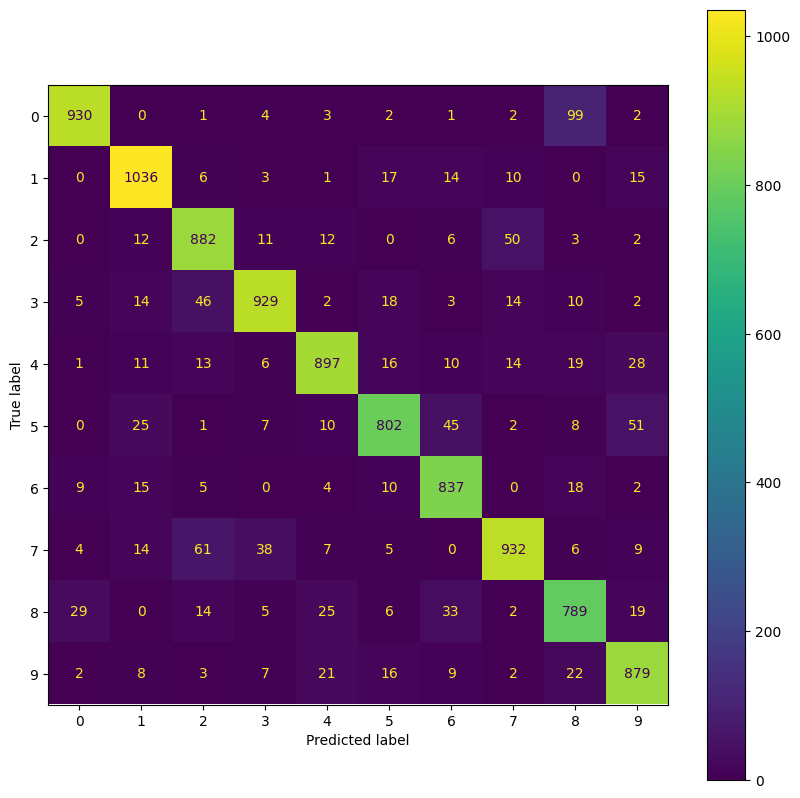

In [39]:
plot_confusion_matrix(best_ridge_ir_snmr[3])

#### Ridge Normalised Error-Only Confusion Matrix (ir snmr)

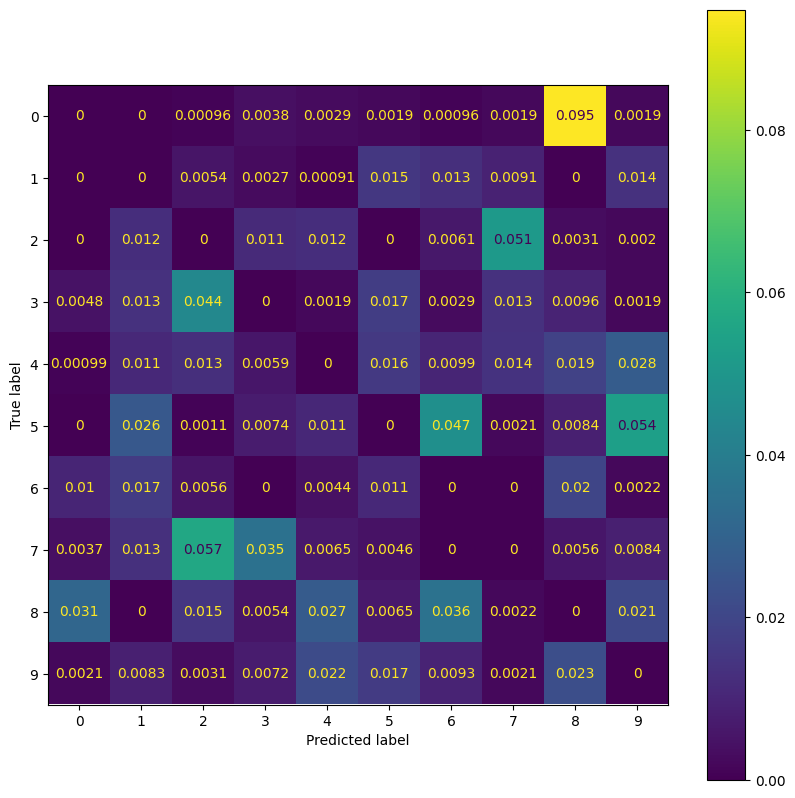

In [40]:
plot_confusion_matrix(best_ridge_ir_snmr[4])

Now we turn our attention to the best Ridge model achieved using the mean and standard deviation renormalised paths.

In [41]:
print(
    "The best Ridge model using the mean and standard deviation renormalised paths "
    "(coming from the transformed location sequences) achieved an "
    f"accuracy_score of {best_ridge_ir_snms[2]} on the testing set "
    f"and corresponds to using the scalefactor {best_ridge_ir_snms[0]}."
)

The best Ridge model using the mean and standard deviation renormalised paths (coming from the transformed location sequences) achieved an accuracy_score of 0.8979 on the testing set and corresponds to using the scalefactor 2.0.


#### Ridge Confusion matrix (ir snms)

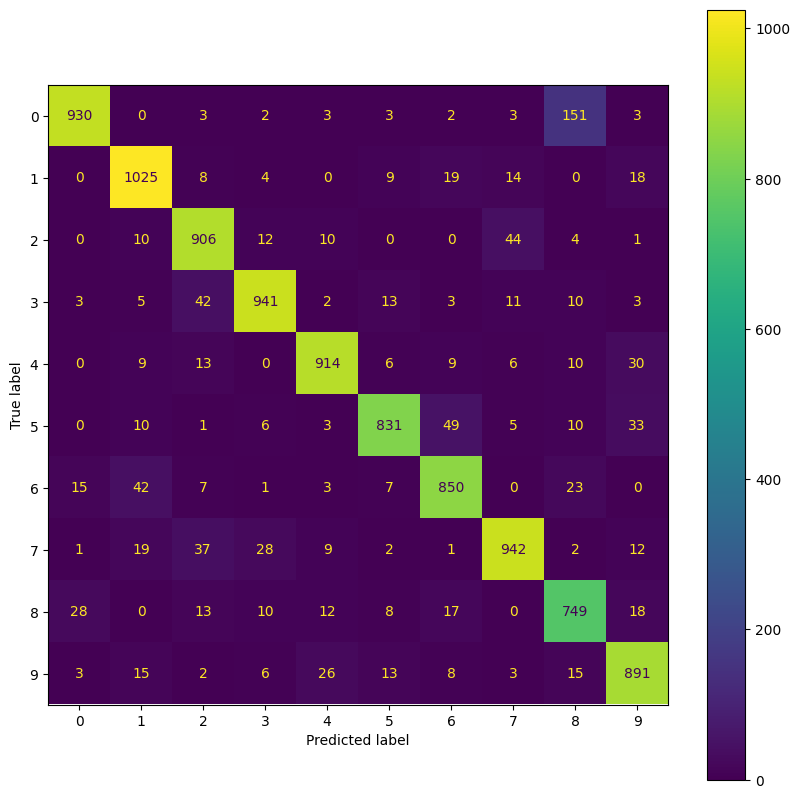

In [42]:
plot_confusion_matrix(best_ridge_ir_snms[3])

#### Ridge Normalised Error-Only Confusion Matrix (ir snms)

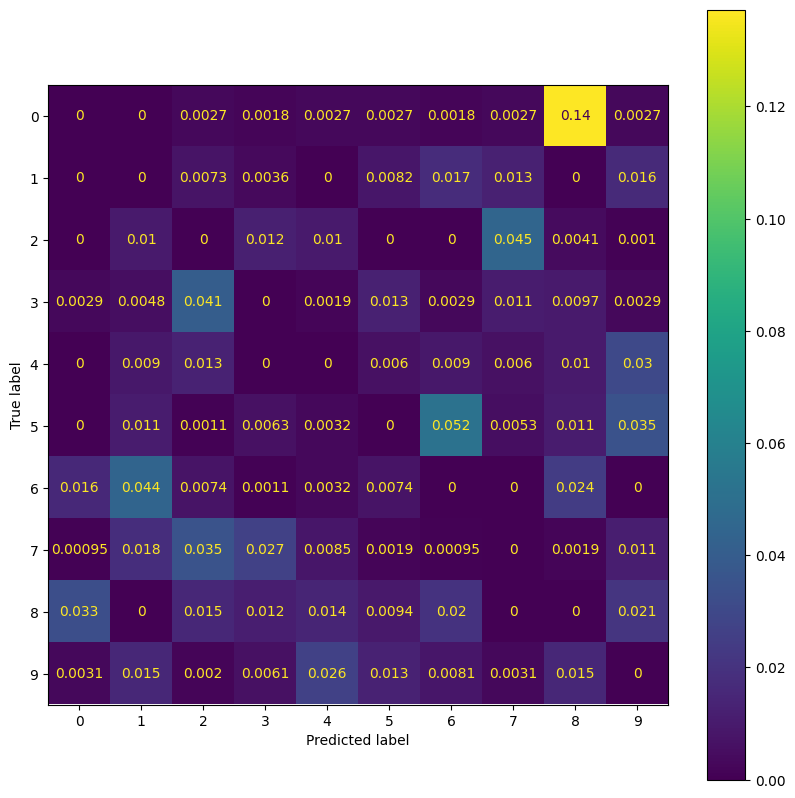

In [43]:
plot_confusion_matrix(best_ridge_ir_snms[4])

Using transformed location sequences has had a positive impact on one part of the 2/7 classification, with an examination of the confusion matrices showing that the number of $2$'s incorrectly classified as a $7$ has been reduced compared to the results obtained using the original location sequences. However, in all but one of the models, the number of $7$'s incorrectly classified as a $2$ has increased, suggesting that the deeper level signature terms were important for this decision. It is also noticeable that using a lower truncation level has deteriorated the performance of some models on other particular comparisons (for example, the RFC models are both now incorrectly classifying more $0$'s as $8$'s than previously).

It is likely that truncating at level $5$ has lost valuable information that was previously useful. The feature set obtained from the transformed sequences consists only of $364$ terms compared to the $511$ obtained from the original location sequences. Depending on the hardware available, the reader may like to try using higher truncation levels with the transformed location sequences. Since this Notebook is designed mainly for illustration we do not do so here. 

### Unsupervised Learning

We now briefly explore what we can achieve _without_ making use of the labels, i.e. without using the lists `train_targets` and `test_targets`. Without access to labels for the data, we will try a _clustering_ approach. That is, to try and split the data into similar groups with the idea that instances belonging to the same group should represent the same digit, even if we do not know what digit that is.

Naively, we may hope that searching for $10$ groups will give good results since there are $10$ distinct digits to recognise, i.e. the $10$ digits $\{0,1,2,3,4,5,6,7,8,9\}$.
We first try this using the Scikit-Learn [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) model searching for $10$ clusters. For this we use the `kmeans_fit` function from `MNIST_funcs`.

In [44]:
help(MNIST_funcs.kmeans_fit)

Help on function kmeans_fit in module MNIST_funcs:

kmeans_fit(a: int, data: list[numpy.array]) -> sklearn.cluster._kmeans.KMeans
    Fit a KMeans cluster model to the input data, using a clusters number of a.
    
    Parameters
    ----------
    a : int
        Integer in [2, len(data) - 1]
    data : list[np.array]
        List of numpy arrays of shape [signature_terms]
    
    Returns
    -------
    KMeans
        KMeans cluster model, with n_clusters = a, fitted to data



We consider signatures coming from both the original location sequences and the transformed sequences. 
We also consider both the mean and range normalised sequences and the mean and standard deviation normalised sequences for each set of signatures. 

In [45]:
from MNIST_funcs import kmeans_fit

N_CLUSTERS = 10
Naive_cluster_snmr = kmeans_fit(a=N_CLUSTERS, data=train_sigs_snmr)
Naive_cluster_snms = kmeans_fit(a=N_CLUSTERS, data=train_sigs_snms)
Naive_cluster_ir_snmr = kmeans_fit(a=N_CLUSTERS, data=train_sigs_ir_snmr)
Naive_cluster_ir_snms = kmeans_fit(a=N_CLUSTERS, data=train_sigs_ir_snms)

/scratch/morley/signature_applications/mnist_classification/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/scratch/morley/signature_applications/mnist_classification/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/scratch/morley/signature_applications/mnist_classification/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We evaluate the performance via the [`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of each model.
This involves using each model to first predict the labels for each instance in the respective collections of signatures.

In [46]:
from sklearn.metrics import silhouette_score

A = silhouette_score(X=train_sigs_snmr, labels=Naive_cluster_snmr.labels_)
B = silhouette_score(X=train_sigs_snms, labels=Naive_cluster_snms.labels_)
C = silhouette_score(X=train_sigs_ir_snmr, labels=Naive_cluster_ir_snmr.labels_)
D = silhouette_score(X=train_sigs_ir_snms, labels=Naive_cluster_ir_snms.labels_)
A, B, C, D

(np.float64(0.34237672731687935),
 np.float64(0.2256593782303922),
 np.float64(0.2810224672962139),
 np.float64(0.19695659811371122))

These scores are not particularly good. 
This isn't that surprising; it is easy to imagine two figure $4$'s that bare little similarity to one and other, for example.
Moreover, as we have seen previously, there are many figure $2$'s that are quite similar to $7$'s, and vice versa.
The issue is that $x$ being a digit $a$ does not guarantee that
 - $x$ very close to all other instances of the digit $a$, and that
 - $x$ is not close to any instance of a digit that is not $a$

### Semi-Supervised Learning

The starting point is noting that each fitted _KMeans_ model returns a centroid element for each cluster it finds. For example, if we look at the Naive_cluster_snmr model that split the train_sigs_snmr into $10$ clusters (which subsequently turned out to be the best number of clusters in terms of silhouette_score), then the centroid elements are displayed via the cell below.

In [47]:
Naive_cluster_snmr.cluster_centers_

array([[ 1.00000000e+00,  1.94456502e-01,  2.81553848e-03, ...,
         7.40172955e-06, -3.27498638e-06,  3.68022956e-08],
       [ 1.00000000e+00, -9.21419107e-01,  9.60767338e-01, ...,
         2.57751418e-06, -4.71207138e-05,  2.06990909e-05],
       [ 1.00000000e+00,  1.00257126e-01, -2.53398494e-02, ...,
        -2.70735418e-04,  3.97164046e-05,  2.81667465e-09],
       ...,
       [ 1.00000000e+00, -1.76774599e-01,  7.22043830e-01, ...,
        -1.77259131e-04,  1.02527149e-04,  6.41112067e-06],
       [ 1.00000000e+00,  8.59215778e-02,  4.38354140e-01, ...,
         1.33024705e-05, -4.82129341e-06,  9.92055165e-07],
       [ 1.00000000e+00,  9.16083033e-01,  9.15092651e-01, ...,
        -3.11588122e-06,  5.13970851e-05,  1.68197459e-05]],
      shape=(10, 511))

We can use the centroid elements found during the _KMeans_ clustering to develop a semi-supervised learning approach as follows:
 - Apply _KMeans_ clustering algorithm to split the signatures into clusters
 - Assign each clusters centroid element its corresponding label
 - Propagate this label out to the closest $a$% of elements in each cluster where $a$ can be chosen by us
 - Use the elements that are given this label as the training set for the various supervised learning models we considered previously
 - Evaluate the performance of the trained models using the untouched testing set

A priori, this appears to require far fewer labelled training instances. For example, the `Naive_cluster_snmr` model returns $10$ clusters, and so we only need to know the labels associated to $10$ of the $60000$ training instances.
**But**, the centroid elements are determined during the clustering, and so it is only **afterwards** that we know which $10$ labels we need. Beforehand, the centroid elements could be any of the $60000$ training instances, meaning we do need to know the labels for _all_ training instances to ensure we can assign the chosen centroid elements there labels.

However, since the subsequent learning is only carried out on labelled data obtained by propagating the centroid labels to the nearest $a$% of their clusters, we can expect the learning to be faster than when we used the full $60000$ training instances (assuming that $a < 100$, of course).

To carry out this strategy we use the `kmeans_percentile_propagate` function from `MNIST_funcs`.

In [48]:
help(MNIST_funcs.kmeans_percentile_propagate)

Help on function kmeans_percentile_propagate in module MNIST_funcs:

kmeans_percentile_propagate(cluster_num: int, percent: float, data: list[numpy.array], labels: list[int]) -> tuple[list[numpy.array], list[int]]
    A KMeans model with cluster_num clusters is used to fit_transform data.
    
    A representative centroid element from each cluster is assigned its
    corresponding label from the labels list.
    
    This label is then propagated to the percent% of the instances in the
    cluster that are closest to the clusters centroid.
    
    The returned output is a list of these chosen instances and a list of the
    corresponding labels for these instances.
    
    Parameters
    ----------
    cluster_num : int
        Integer in [2, len(data) - 1]
    percent : float
        Float in [0, 100]
    data : list[np.array]
        List of numpy arrays of shape [signature_terms]
    labels : list[int]
        List of integer labels marking the number corresponding to each sequen

We apply `kmeans_percentile_propagate` to the four collections of training signatures that we have previously used with the choice of percent $=10$.

In [49]:
from MNIST_funcs import kmeans_percentile_propagate

P = 10

train_sigs_snmr_P, train_targets_snmr_P = kmeans_percentile_propagate(
    cluster_num=10,
    percent=P,
    data=train_sigs_snmr,
    labels=train_targets,
)

train_sigs_snms_P, train_targets_snms_P = kmeans_percentile_propagate(
    cluster_num=15,
    percent=P,
    data=train_sigs_snms,
    labels=train_targets,
)

train_sigs_ir_snmr_P, train_targets_ir_snmr_P = kmeans_percentile_propagate(
    cluster_num=20,
    percent=P,
    data=train_sigs_ir_snmr,
    labels=train_targets,
)

train_sigs_ir_snms_P, train_targets_ir_snms_P = kmeans_percentile_propagate(
    cluster_num=50,
    percent=P,
    data=train_sigs_ir_snms,
    labels=train_targets,
)

### Level 8 Truncated Signatures of Paths from Location Sequences with Mean and Range Normalisation

We train a Ridge model on the propagated set of signatures arising from the level $8$ truncated signatures of the paths from the mean and range normalised location sequences.

In [50]:
SIGNATURE_LEVEL = 8

ridge_results_snmr_P, ridge_best_result_snmr_P = ridge_scale_learn(
    scale_factors=E,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_snmr_P,
    labels=train_targets_snmr_P,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

Now we examine the performance of the best trained models of each type on the testing set.

In [51]:
best_ridge_snmr_P = model_performance(
    B=ridge_best_result_snmr_P,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_snmr,
    labels=test_targets,
    cpu_number=N_CPU,
)

In [52]:
print(
    f"The best Ridge model achieves an accuracy_score of {best_ridge_snmr_P[2]} "
    f"using a scalefactor of {best_ridge_snmr_P[0]}."
)

The best Ridge model achieves an accuracy_score of 0.6296 using a scalefactor of 4.0.


Once again, we carry out a more detailed examination by looking at the confusion matrices and the normalised confusion matrices focusing only on the incorrect classifications.

#### Ridge Confusion Matrix

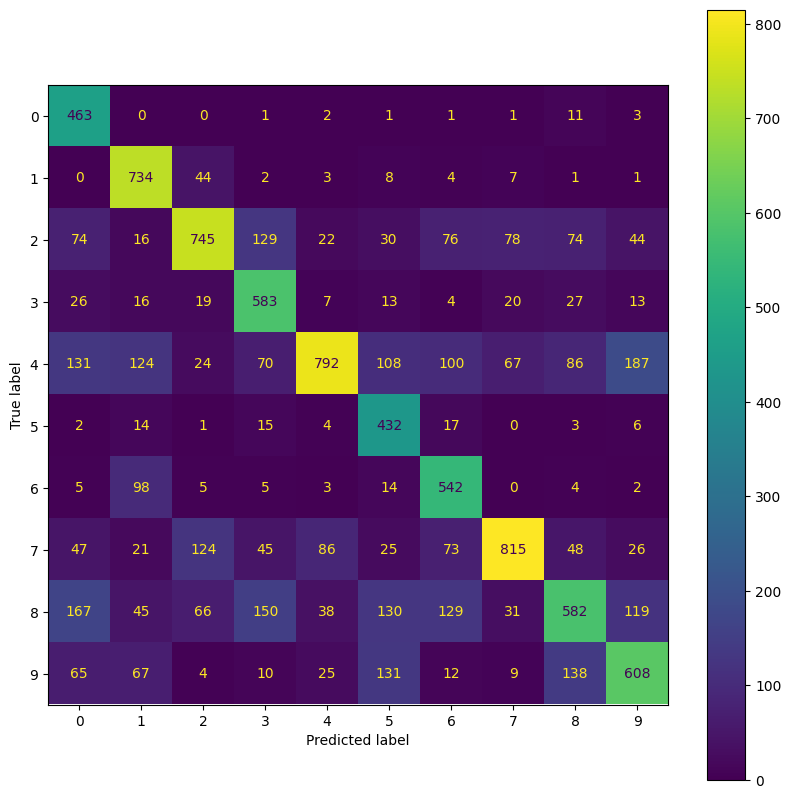

In [53]:
plot_confusion_matrix(best_ridge_snmr_P[3])

#### Ridge Normalised Error-Only Confusion Matrix

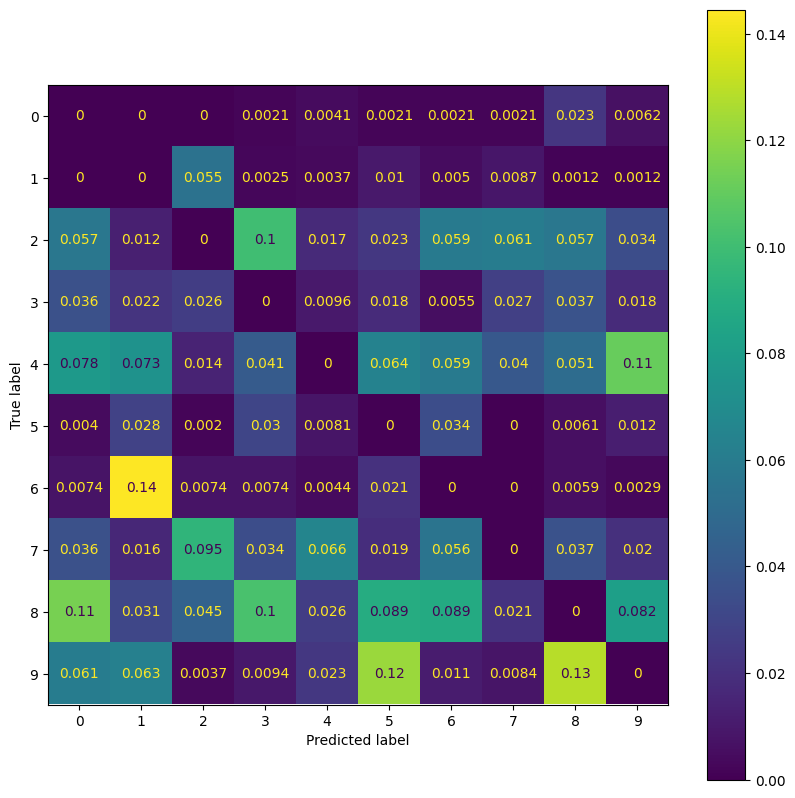

In [54]:
plot_confusion_matrix(best_ridge_snmr_P[4])

### Level 8 Truncated Signatures of Paths from Location Sequences with Mean and Standard Deviation Normalisation

We train a Ridge model on the propagated set of signatures arising from the level $8$ truncated signatures of the paths from the mean and standard deviation normalised location sequences.

In [55]:
ridge_results_snms_P, ridge_best_result_snms_P = ridge_scale_learn(
    scale_factors=EB,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_snms_P,
    labels=train_targets_snms_P,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

Now we examine the performance of the best models of each type on the testing set.

In [56]:
best_ridge_snms_P = model_performance(
    B=ridge_best_result_snms_P,
    dim=2,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_snms,
    labels=test_targets,
    cpu_number=N_CPU,
)

print(
    f"The best Ridge model achieves an accuracy_score of {best_ridge_snms_P[2]} "
    f"using a scalefactor of {best_ridge_snms_P[0]}."
)

The best Ridge model achieves an accuracy_score of 0.6045 using a scalefactor of 2.0.


A more detailed examination of the performance can be carried out from the confusion matrices and the normalised error-only confusion matrices.

#### Ridge Confusion Matrix

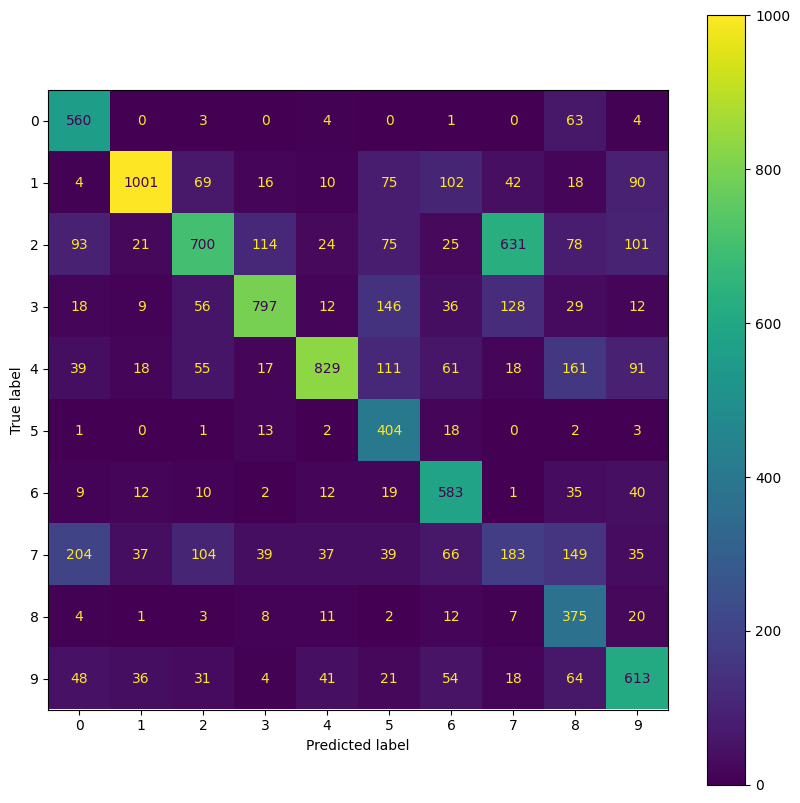

In [57]:
plot_confusion_matrix(best_ridge_snms_P[3])

#### Ridge Normalised Error-Only Confusion Matrix

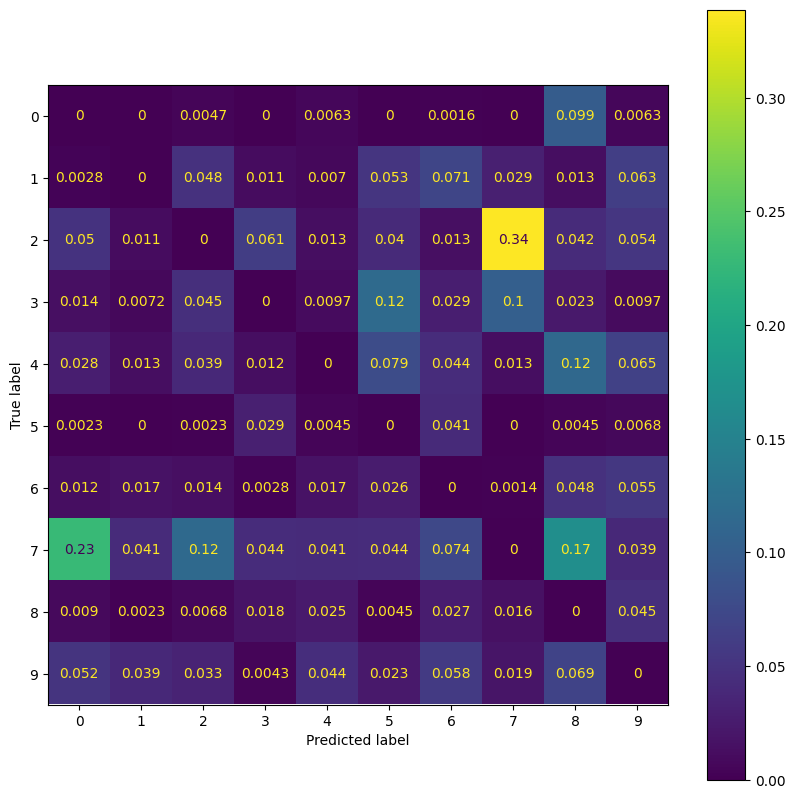

In [58]:
plot_confusion_matrix(best_ridge_snms_P[4])

### Level 5 Truncated Signatures of Paths from Transformed Location Sequences with Mean and Range Normalisation

We train a Ridge model  on the propagated set of signatures arising as the level 5 truncated signatures of the paths from the mean and range normalised transformed location sequences.

In [59]:
SIGNATURE_LEVEL = 5

ridge_results_ir_snmr_P, ridge_best_result_ir_snmr_P = ridge_scale_learn(
    scale_factors=E,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_ir_snmr_P,
    labels=train_targets_ir_snmr_P,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

Now examine the performance of the best models of each type on the testing set.

In [60]:
best_ridge_ir_snmr_P = model_performance(
    B=ridge_best_result_ir_snmr_P,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_ir_snmr,
    labels=test_targets,
    cpu_number=N_CPU,
)

print(
    f"The best Ridge model achieves an accuracy_score of {best_ridge_ir_snmr_P[2]} "
    f"using a scalefactor of {best_ridge_ir_snmr_P[0]}."
)

The best Ridge model achieves an accuracy_score of 0.8013 using a scalefactor of 4.0.


Again a more detailed examination of the performances can be achieved by viewing the confusion matrices and the normalised error-only confusion matrices.

#### Ridge Confusion Matrix

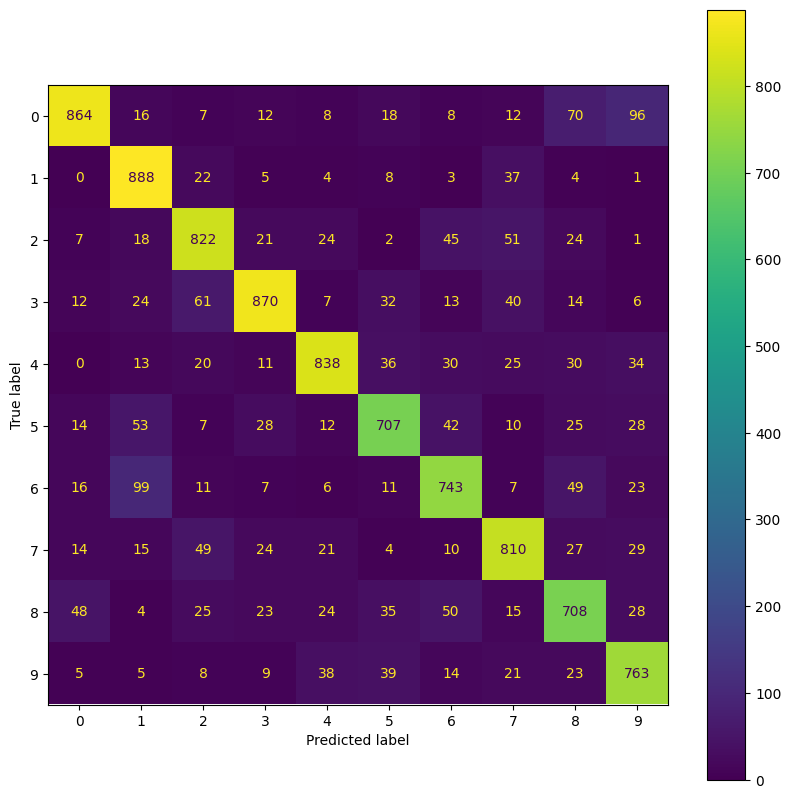

In [61]:
plot_confusion_matrix(best_ridge_ir_snmr_P[3])

#### Ridge Normalised Error-Only Confusion Matrix

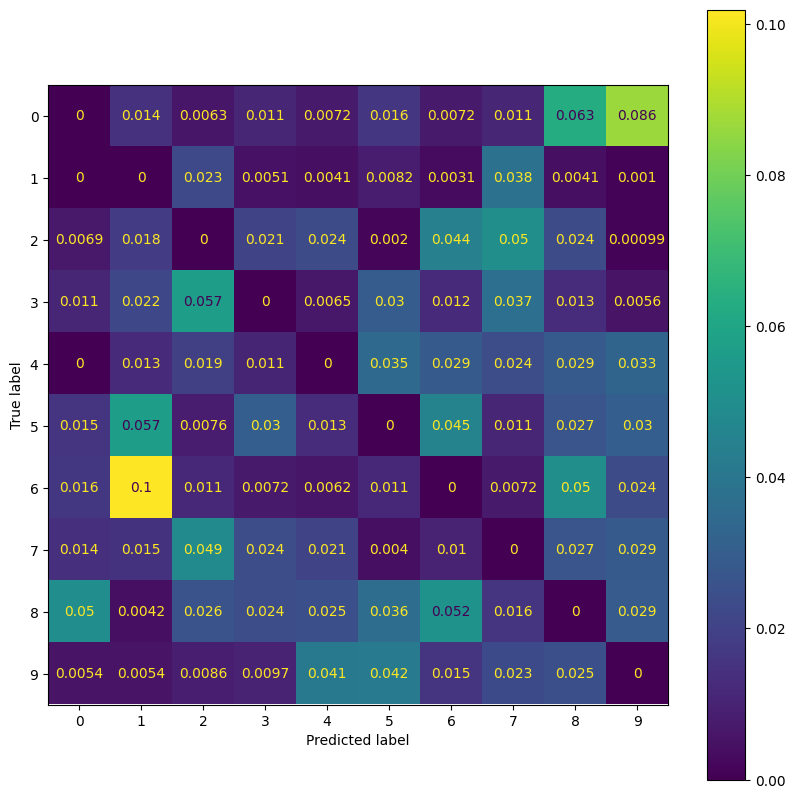

In [62]:
plot_confusion_matrix(best_ridge_ir_snmr_P[4])

### Level 5 Truncated Signatures of Paths from Transformed Location Sequences with Mean and Standard Deviation Normalisation

We train a Ridge model on the propagated set of signatures arising as the level 5 truncated signatures of the paths from the mean and standard deviation normalised transformed location sequences.

In [63]:
ridge_results_ir_snms_P, ridge_best_result_ir_snms_P = ridge_scale_learn(
    scale_factors=EB,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=train_sigs_ir_snms_P,
    labels=train_targets_ir_snms_P,
    reg=[np.array((0.01, 0.1, 1.0, 10.0))],
    cpu_number_one=N_CPU // 4,
    cpu_number_two=N_CPU // 4,
)

Now examine the performance of the best models of each type on the test set.

In [64]:
best_ridge_ir_snms_P = model_performance(
    B=ridge_best_result_ir_snms_P,
    dim=3,
    depth=SIGNATURE_LEVEL,
    data=test_sigs_ir_snms,
    labels=test_targets,
    cpu_number=N_CPU,
)

print(
    f"The best Ridge model achieves an accuracy_score of {best_ridge_ir_snms_P[2]} "
    f"using a scalefactor of {best_ridge_ir_snms_P[0]}."
)

The best Ridge model achieves an accuracy_score of 0.8252 using a scalefactor of 2.0.


Again a more detailed examination of the performance may be obtained by viewing the confusion matrices and the normalised error-only confusion matrices.

#### Ridge Confusion Matrix

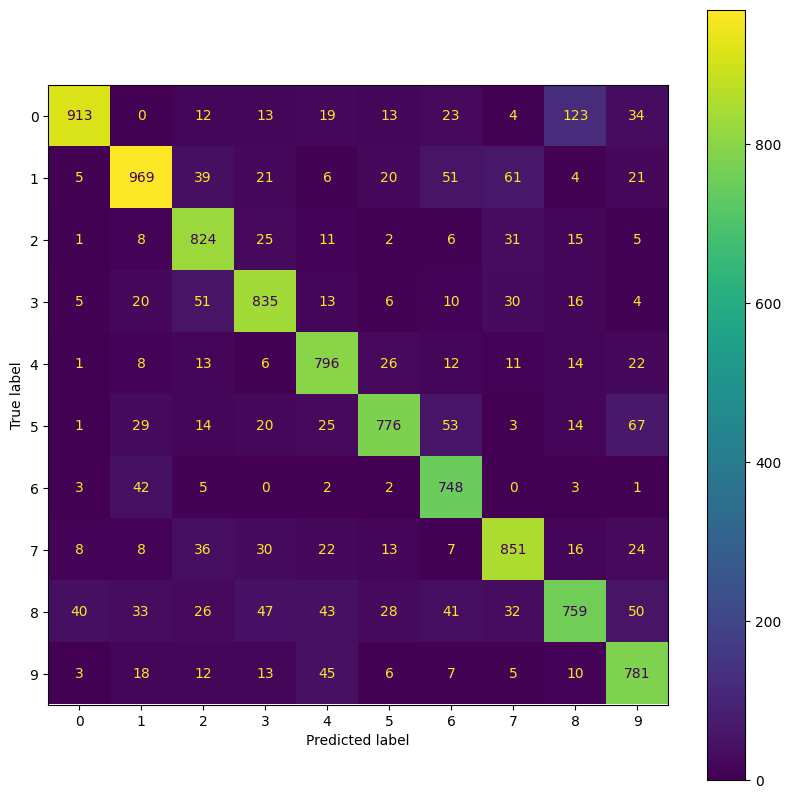

In [65]:
plot_confusion_matrix(best_ridge_ir_snms_P[3])

#### Ridge Normalised Error-Only Confusion Matrix

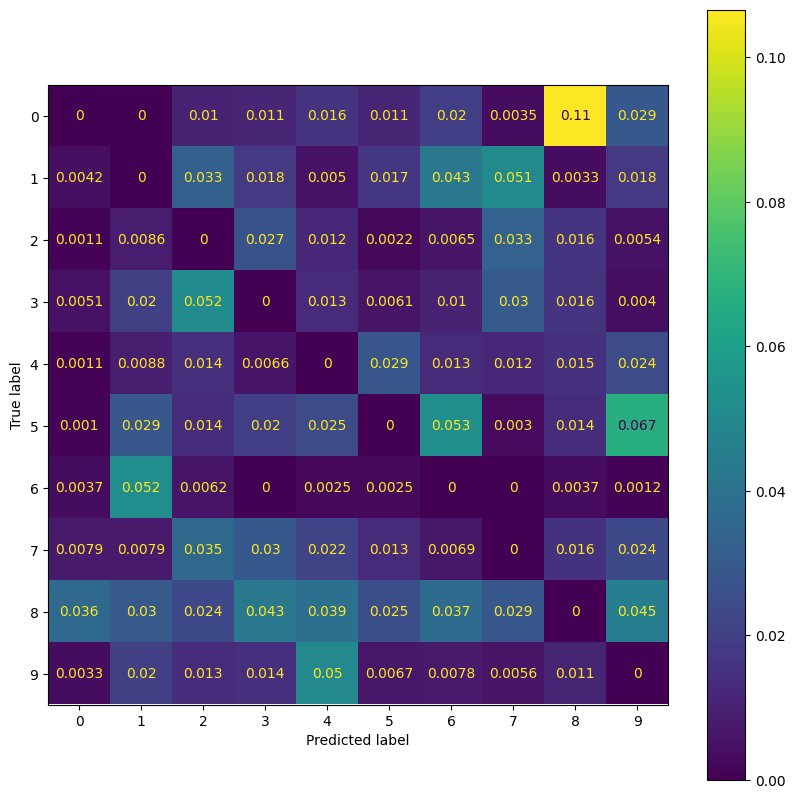

In [66]:
plot_confusion_matrix(best_ridge_ir_snms_P[4])